In [1]:
from diffusers import ControlNetModel, DiffusionPipeline, StableDiffusionXLControlNetPipeline, AutoencoderKL, StableDiffusionControlNetPipeline, UniPCMultistepScheduler
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2

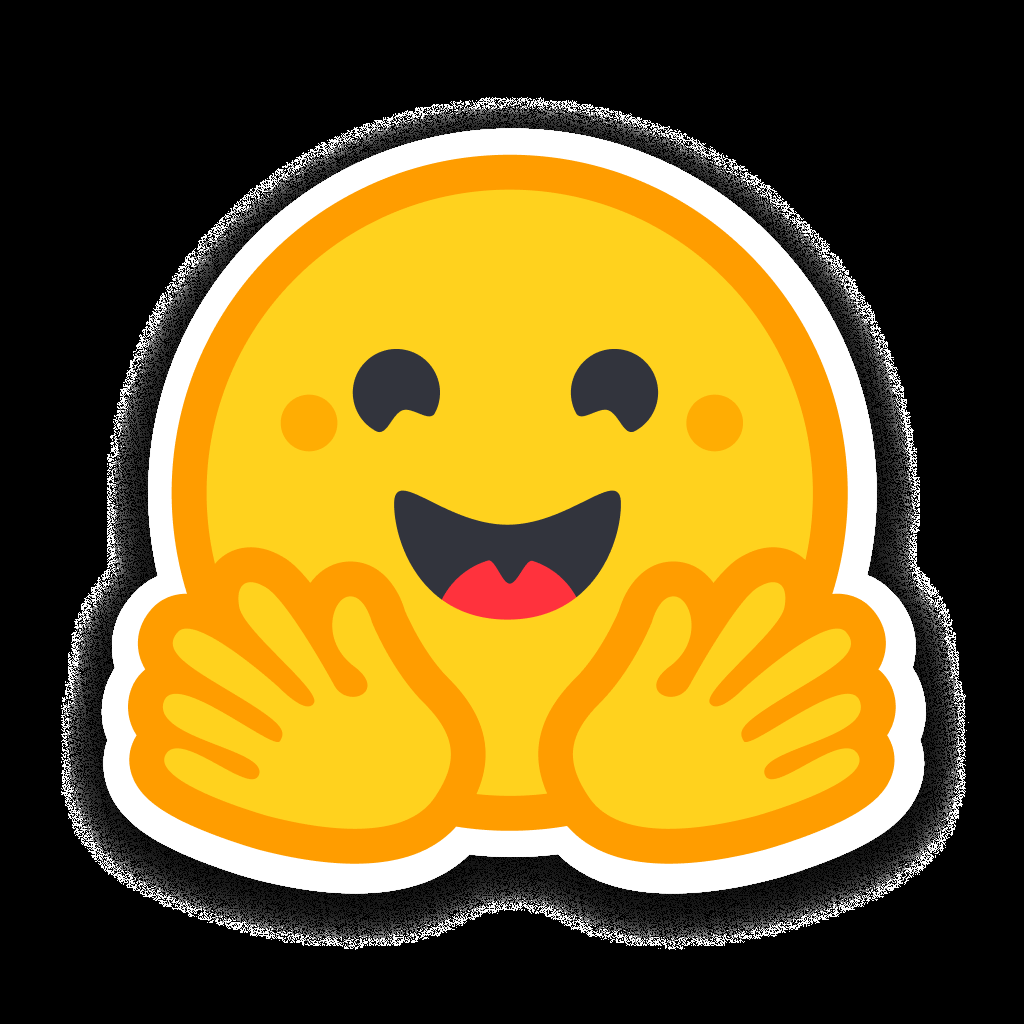

In [2]:
image = load_image("https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png")
image

In [3]:

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16,
)
base_pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
base_pipe.scheduler = UniPCMultistepScheduler.from_config(base_pipe.scheduler.config)
base_pipe.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base_pipe.text_encoder_2,
    vae=base_pipe.vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
refiner.scheduler = UniPCMultistepScheduler.from_config(refiner.scheduler.config)
refiner.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
image = np.array(image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

In [6]:
prompt = "aerial view, a futuristic research complex in a bright foggy jungle, hard lighting"
negative_prompt = 'low quality, bad quality, sketches'

controlnet_conditioning_scale = 0.5  # recommended for good generalization

  0%|          | 0/50 [00:00<?, ?it/s]

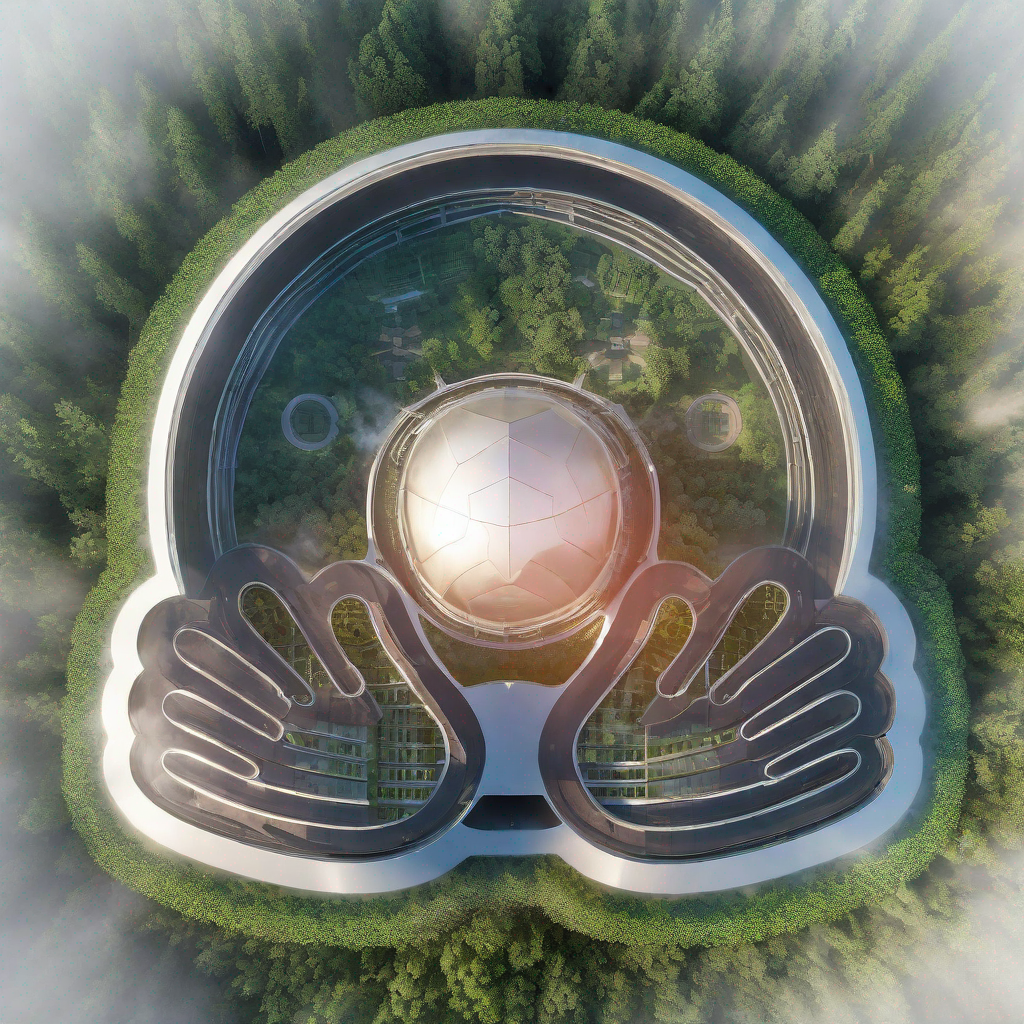

In [7]:
non_latent_image = base_pipe(
    prompt, negative_prompt=negative_prompt, image=canny_image, controlnet_conditioning_scale=controlnet_conditioning_scale
).images
non_latent_image[0]

In [8]:
latent_image = base_pipe(
    prompt, negative_prompt=negative_prompt, image=canny_image, controlnet_conditioning_scale=controlnet_conditioning_scale, output_type="latent"
    ).images

refined_image = refiner(
    prompt=prompt, negative_prompt=negative_prompt, image=latent_image
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

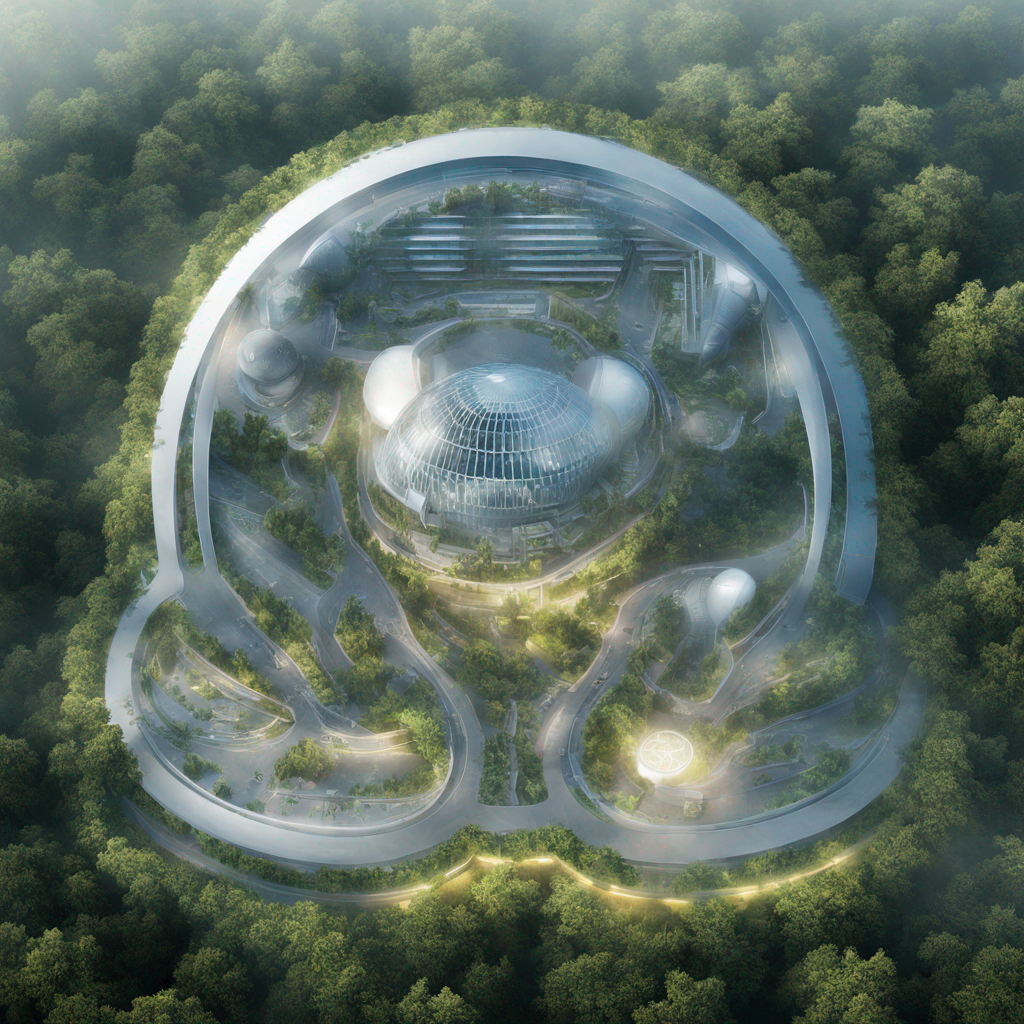

In [9]:
refined_image